In [9]:
import sqlite3
import base64
import json
import os
import traceback
from fvcore.common.timer import Timer
# import tempfile
# import uuid
# from io import BytesIO
#
import cv2
import matplotlib.pyplot as plt

In [7]:
class YOLO_single_img():
    def __init__(self, configPath="cfg/yolo-obj.cfg", weightPath="weights/yolo-obj_final.weights",
                 metaPath="cfg/obj.data",
                 gpu_id=0):
        import darknet
        from darknet import set_gpu
        self.metaMain, self.netMain, self.altNames, self.dark, self.tt = None, None, None, darknet, Timer()
        set_gpu(gpu_id)
        if not os.path.exists(configPath):
            raise ValueError("Invalid config path `" +
                             os.path.abspath(configPath) + "`")
        if not os.path.exists(weightPath):
            raise ValueError("Invalid weight path `" +
                             os.path.abspath(weightPath) + "`")
        if not os.path.exists(metaPath):
            raise ValueError("Invalid data file path `" +
                             os.path.abspath(metaPath) + "`")
        if self.netMain is None:
            self.netMain = darknet.load_net_custom(configPath.encode(
                "ascii"), weightPath.encode("ascii"), 0, 1)  # batch size = 1
        if self.metaMain is None:
            self.metaMain = darknet.load_meta(metaPath.encode("ascii"))
        if self.altNames is None:
            try:
                with open(metaPath) as metaFH:
                    metaContents = metaFH.read()
                    import re
                    match = re.search("names *= *(.*)$", metaContents,
                                      re.IGNORECASE | re.MULTILINE)
                    if match:
                        result = match.group(1)
                    else:
                        result = None
                    try:
                        if os.path.exists(result):
                            with open(result) as namesFH:
                                namesList = namesFH.read().strip().split("\n")
                                self.altNames = [x.strip() for x in namesList]
                    except TypeError:
                        pass
            except Exception:
                pass

    def darkdetect(self, image_src):
        darknet_image = self.dark.make_image(self.dark.network_width(self.netMain),
                                             self.dark.network_height(self.netMain), 3)
        self.tt.reset()
        try:
            frame_rgb = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
            frame_resized = cv2.resize(frame_rgb,
                                       (self.dark.network_width(self.netMain),
                                        self.dark.network_height(self.netMain)),
                                       interpolation=cv2.INTER_LINEAR)
            self.dark.copy_image_from_bytes(darknet_image, frame_resized.tobytes())
            detections = self.dark.detect_image(self.netMain, self.metaMain, darknet_image, thresh=0.25)
            for d in detections:
                print(d)
            return detections
        except:
            raise

def convertBack(x, y, w, h):
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax


def cvDrawBoxes(detections, img):
    for detection in detections:
        x, y, w, h = detection[2][0], \
                     detection[2][1], \
                     detection[2][2], \
                     detection[2][3]
        xmin, ymin, xmax, ymax = convertBack(
            float(x), float(y), float(w), float(h))
        pt1 = (xmin, ymin)
        pt2 = (xmax, ymax)
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), 1)
        cv2.putText(img,
                    detection[0].decode() +
                    " [" + str(round(detection[1] * 100, 2)) + "]",
                    (pt1[0], pt1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    [0, 255, 0], 2)
    return img

In [10]:
yoyo = YOLO_single_img()
img=cv2.imread('mq291bb92e000113-155449.jpg')
dd=yoyo.darkdetect(img)

(b'mask-cap', 0.8388882279396057, (475.039306640625, 331.3424072265625, 23.978389739990234, 48.884986877441406))
(b'mask-head', 0.7727656960487366, (442.577880859375, 332.8180847167969, 25.785188674926758, 48.01731872558594))


In [13]:
json.dumps(dd)

TypeError: Object of type 'bytes' is not JSON serializable

In [27]:
frame_resized = cv2.resize(img,(608, 608),interpolation=cv2.INTER_LINEAR)
image = cvDrawBoxes(dd, frame_resized)
# image = cv2.cvtColor(cv2.imread('mq291bb92e000113-155449.jpg'), cv2.COLOR_BGR2RGB)

In [19]:
dd

[(b'mask-cap',
  0.8388882279396057,
  (475.039306640625,
   331.3424072265625,
   23.978389739990234,
   48.884986877441406)),
 (b'mask-head',
  0.7727656960487366,
  (442.577880859375,
   332.8180847167969,
   25.785188674926758,
   48.01731872558594))]

In [26]:
json.dumps(b'mask-cap'.decode())

'"mask-cap"'

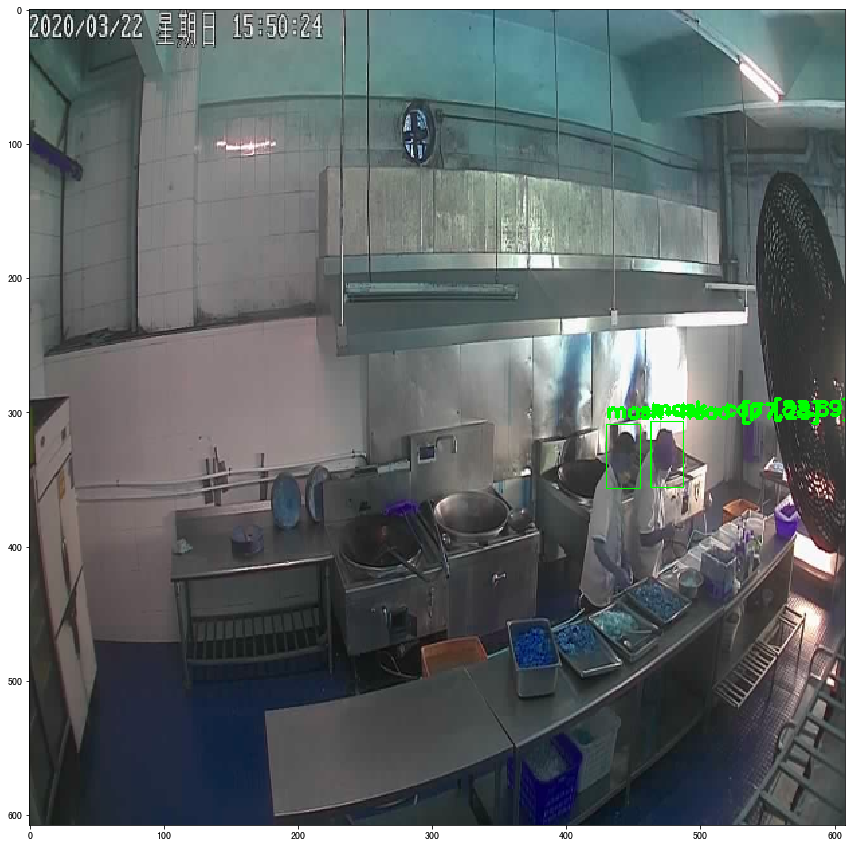

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(image)

In [4]:
#importing the requests library
import base64
import requests
%pylab inline 
import json
from io import BytesIO
from tensorflow.keras.preprocessing import image
# defining the api-endpoint
API_ENDPOINT = "http://192.168.8.8:5123/pictureResults"
image_path = '/opt/work/chefCap/apis/'
image_path +='mq291bb92e000113-155449.jpg'
b64_image = ""
# Encoding the JPG,PNG,etc. image to base64 format
with open(image_path, "rb") as imageFile:
    b64_image = base64.b64encode(imageFile.read())

# data to be sent to api
data = {'IMG_BASE64': b64_image}

# sending post request and saving response as response object
r = requests.post(url=API_ENDPOINT, data=data)

Populating the interactive namespace from numpy and matplotlib


In [5]:
b64_image

b'/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDDsvD17faV/ack2m6ZYtJ5cMmqXDW/nfLu+X5aj1Hw1fWelf2rHNpup2SyeXJJpczXHk/Lu+b5ajghvtUksdJtGvrv5l8m3aaaSOH+Hd/squ6ui1HUIfDHhy48JaZdLe394v8AxNZ/lkjh3R+Wyrt2/N+7rL3QOJg0u81bUo